# Dataset conll04

This dataset is constructed from news articles and has 

In [2]:
import sys
sys.path.insert(0,'..')
import json
from abc import abstractmethod, ABC
from collections import OrderedDict
from logging import Logger
from typing import List
from tqdm import tqdm
from transformers import BertTokenizer

from spert import util, models, prediction,  sampling
from spert.entities import Dataset, EntityType, RelationType, Entity, Relation, Document
from spert.opt import spacy
from spert.evaluator import Evaluator
from spert.input_reader import JsonInputReader, BaseInputReader
from spert.loss import SpERTLoss, Loss
from spert.trainer import BaseTrainer
from spert.models import SpERT,SpROB, SpLONG

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from logging import raiseExceptions
import math
import os
from typing import Type
from unittest import case

import torch
from torch.nn import DataParallel
from torch.optim import Optimizer
import transformers
from torch.utils.data import DataLoader
from transformers import AdamW, BertConfig,RobertaConfig,LongformerConfig  
from transformers import BertTokenizer,RobertaTokenizer,LongformerTokenizer



## Entities and Relation Types
Both types are in file `conll04_types.json` and can be extracted as follows: 

In [3]:

types_path = "../data/datasets/conll04/conll04_types.json"

types = json.load(open(types_path), object_pairs_hook=OrderedDict)
entity_types = pd.DataFrame(types['entities']).transpose()
relation_types = pd.DataFrame(types['relations']).transpose()

relation_types

,short,verbose,symmetric
Work_For,Work,Work for,False
Kill,Kill,Kill,False
OrgBased_In,OrgBI,Organization based in,False
Live_In,Live,Live in,False
Located_In,LocIn,Located in,False


In [4]:
entity_types

,short,verbose
Loc,Loc,Location
Org,Org,Organization
Peop,Peop,People
Other,Other,Other


## Data Splits

The data are pre-split into train, train-dev, 

In [6]:
paths = ["../data/datasets/conll04/conll04_train.json",
         #"../data/datasets/conll04/conll04_train_dev.json",
         "../data/datasets/conll04/conll04_dev.json",
         "../data/datasets/conll04/conll04_test.json"]
#labels = ["train","train_dev","dev","test"]
labels = ["train","dev","test"]
data_splits = {}
for pth, label in zip(paths,labels):
    data_splits[label] = json.load(open(pth), object_pairs_hook=OrderedDict)
data_splits.keys()


dict_keys(['train', 'dev', 'test'])

In [8]:
ex1 = data_splits['test'][100]


The train-dev set is the union of train and dev as shown below:

In [9]:
[ "%s has %i examples"%(l,len(s)) for l,s in data_splits.items()]

['train has 922 examples', 'dev has 231 examples', 'test has 288 examples']

The size  of each train-dev example measured as token count:
 

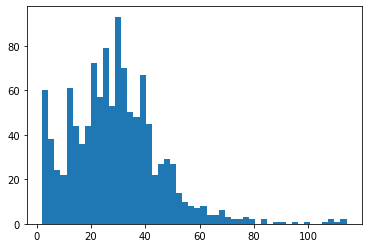

In [10]:
sizes = [len(ex['tokens']) for  ex in data_splits['train']+data_splits['dev'] ]
plot_bins = plt.hist(sizes, bins=50)
#plot_bins

In [21]:
seq1 = data_splits['train'][20]['tokens']

In [49]:
from transformers import RobertaTokenizer
bertTok = BertTokenizer.from_pretrained('bert-base-cased',do_lower_case=False,cache_dir=None,do_basic_tokenize=False)
robTok  = RobertaTokenizer.from_pretrained('roberta-base')
print(seq1)
print(bertTok.encode_plus(seq1))
print(robTok.encode_plus(seq1))


['But', 'Sen.', 'Strom', 'Thurmond', ',', 'R-S.C.', ',', 'sponsor', 'of', 'a', 'proposed', 'constitutional', 'amendment', ',', 'said', ',', '`', '`', 'An', 'overwhelming', 'majority', 'of', 'Americans', 'are', 'looking', 'to', 'the', 'Congress', 'to', '...', 'restore', 'the', 'proper', 'civil', 'respect', 'for', 'our', 'American', 'flag.', "'", "'"]
{'input_ids': [101, 1252, 100, 100, 100, 117, 100, 117, 10767, 1104, 170, 3000, 7950, 12669, 117, 1163, 117, 169, 169, 1760, 10827, 2656, 1104, 4038, 1132, 1702, 1106, 1103, 2757, 1106, 1232, 9176, 1103, 4778, 2987, 4161, 1111, 1412, 1237, 100, 112, 112, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'input_ids': [0, 1708, 3, 3, 3, 6, 3, 6, 3, 1116, 102, 3, 41899, 3, 6, 28613, 6, 12905, 

In [42]:
mtype = 'splong'
model_class = models.get_model(mtype)

if mtype == 'spert':
    model_name = 'bert-base-cased'
    config = BertConfig.from_pretrained(model_name, cache_dir=None)
    tokenizer = BertTokenizer.from_pretrained(model_name,do_lower_case=False,cache_dir=None)
elif mtype == 'sprob':
    model_name = 'roberta-base'
    tokenizer = RobertaTokenizer.from_pretrained(model_name,do_lower_case=False,cache_dir=None)
    config = RobertaConfig.from_pretrained(model_name, cache_dir=None)
elif mtype == 'splong':
    model_name = 'allenai/longformer-base-4096'
    tokenizer = LongformerTokenizer.from_pretrained(model_name,do_lower_case=False,cache_dir=None)
    config = LongformerConfig.from_pretrained(model_name, cache_dir=None)
else:
    raise Exception("Argument model_type must be one of %s"%['spert','sprob','splong'])

util.check_version(config, model_class, model_name)
print(model_name)

Downloading: 100%|██████████| 878k/878k [00:00<00:00, 10.8MB/s]
Downloading: 100%|██████████| 446k/446k [00:00<00:00, 7.35MB/s]
Downloading: 100%|██████████| 1.29M/1.29M [00:00<00:00, 9.55MB/s]
Downloading: 100%|██████████| 694/694 [00:00<00:00, 229kB/s]


allenai/longformer-base-4096


In [43]:

config.spert_version = model_class.VERSION
config.spert_version

'1.1'

In [44]:
model = model_class.from_pretrained(model_name,
                                    config=config,
                                    # SpERT model parameters
                                    #cls_token=self._tokenizer.convert_tokens_to_ids('[CLS]'),
                                    cls_token=tokenizer.cls_token_id,
                                    relation_types=4,
                                    entity_types=5,
                                    max_pairs=1000,
                                    prop_drop=0.1,
                                    size_embedding=25,
                                    freeze_transformer=False,
                                    cache_dir=None
                                    )


Downloading: 100%|██████████| 570M/570M [00:32<00:00, 18.6MB/s] 
Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing SpLONG: ['longformer.encoder.layer.0.attention.self.key_global.weight', 'longformer.encoder.layer.2.attention.self.query.weight', 'longformer.encoder.layer.2.attention.self.value_global.bias', 'longformer.encoder.layer.6.attention.self.key_global.bias', 'longformer.encoder.layer.2.attention.self.query_global.bias', 'longformer.encoder.layer.5.attention.self.key_global.bias', 'longformer.encoder.layer.9.output.dense.bias', 'longformer.encoder.layer.9.output.LayerNorm.weight', 'longformer.encoder.layer.5.attention.self.query_global.weight', 'longformer.encoder.layer.2.output.LayerNorm.weight', 'longformer.encoder.layer.0.attention.self.value.bias', 'longformer.encoder.layer.4.attention.self.query_global.bias', 'longformer.encoder.layer.3.attention.self.query_global.bias', 'longformer.encoder.layer.4.intermediate.dense.bias',